In [172]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# ALEXIS TSIPRAS' WORD NETWORKS FROM 8 FEBRUARY TO 11 JULY 2015: Word Co-Occurrences in Sentences of Two Speeches of the Greek Prime Minister Alexis Tsipras

## By Moses Boudourides, D. Dimitrakopoulou, Sergios Lenis & Pantelis Vikatos


**IMPORTANT**: To use this notebook, you'll need to

1. Install IPython Notebook (easiest way: use [Anaconda](http://store.continuum.io))
2. Download this notebook and all other Python scripts used here from [https://github.com/mboudour/WordNets](https://github.com/mboudour/WordNets)
3. Run `ipython notebook` in the same directory where notebook and scripts were put

<a href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="http://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

In [173]:
# All these imports are needed for the following cells to run

import nltk
import os
import re
# import csv
import itertools
from nltk.tokenize import sent_tokenize, word_tokenize
import networkx as nx
import matplotlib.pyplot as plt
# from matplotlib.patches import Ellipse, Polygon
import numpy as np
# import math
# import random
import codecs
from textblob import TextBlob
import pandas as pd
%matplotlib inline 
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


* The transcript of Tsipras' 8-02-2015 was downloaded from http://www.primeminister.gov.gr/english/2015/02/08/primeministers-a-tsipras-speech-during-the-programmatic-statements-of-the-government/ (accessed on 22-03-2016)
* The transcript of Tsipras' on 11-07-2015 was downloaded from http://www.primeminister.gov.gr/english/2015/07/11/prime-minister-alexis-tsipras-speech/ (accessed on 22-03-2016)

In [174]:
## Opening and reading the two speeches in NLTK

In [175]:
# Opening and reading the two speeches in NLTK

f1 = codecs.open('t1.txt', "r", encoding="utf-8")
f2 = codecs.open('t2.txt', "r", encoding="utf-8")
f1Temp = codecs.open("tempASCII", "w", encoding="ascii", errors="ignore")
f2Temp = codecs.open("tempASCII", "w", encoding="ascii", errors="ignore")
f1Temp.write('t1_02_15.txt')
f2Temp.write('t2_07_15.txt')
HClinton=f1.read()
BSanders=f2.read()

## Noun phrases are extracted from the two speeches using TextBlob

In [176]:
# Noun phrases are extracted from the two speeches using TextBlob

blobHClinton = TextBlob(HClinton)
blobBSanders = TextBlob(BSanders)
nounHC=blobHClinton.np_counts
nounBS = blobBSanders.np_counts
title1="Tsipras' 8 February 2015"
title2="Tsipras' 11 July 2015"
dfnp1=pd.DataFrame(columns=["%s noun phrases" %title1, "Frequencies"])
dfnp2=pd.DataFrame(columns=["%s noun phrases" %title2, "Frequencies"])
u=1
for l in nounHC: 
    dfnp1.loc[u]=[l,nounHC[l]]
    u+=1
u=1
for l in nounBS: 
    dfnp2.loc[u]=[l,nounBS[l]]                  
    u+=1

print "The total number of noun phrases in %s speech is %i. The following table shows the first 5 entries." %(title1,len(nounHC))
dfnp1.head(5)
# To see all the noun phrases in H Clinton's speech just run dfnp1 above

The total number of noun phrases in Tsipras' 8 February 2015 speech is 659. The following table shows the first 5 entries.


,Tsipras' 8 February 2015 noun phrases,Frequencies
1,important role,1
2,secondly,3
3,notorious email,1
4,agricultural production,1
5,small corruption,1


In [177]:
print "The total number of noun phrases in %s speech is %i. The following table shows the first 5 entries." %(title2,len(nounBS))
dfnp2.head(5)
# To see all the noun phrases in B Sanders' speech just run dfnp2 above

The total number of noun phrases in Tsipras' 11 July 2015 speech is 173. The following table shows the first 5 entries.


,Tsipras' 11 July 2015 noun phrases,Frequencies
1,national duty,1
2,september,1
3,substantive discussion,1
4,forty-eight hours,1
5,whitewash things –,1


## Common noun phrases in the two Tsipras' speeches

In [178]:
# Common noun phrases in H Clinton's and B Sanders speech

common={}
ncommon={}
dfc=pd.DataFrame(columns=["Common noun phrases", title1, title2])
u=1
for l in nounHC:  
    if l in nounBS:
        common[l]=min(nounHC[l],nounBS[l])
        ncommon[l]=(nounHC[l],nounBS[l])        
        dfc.loc[u]=[l,nounHC[l],nounBS[l]]
        u+=1
dfc

,Common noun phrases,Tsipras' 8 February 2015,Tsipras' 11 July 2015
1,greek people,15,11
2,greek bonds,1,1
3,collective redundancies,1,1
4,popular sovereignty,2,1
5,sustainable agreement,1,1
6,debt issue,1,1
7,thank,1,1
8,european union,4,1
9,prime,1,2
10,greece,22,2


In [179]:
#The following noun phrases were removed:

to_be_removed = ['prime','ladies','gentlemen']#[u'well',u'thank',u'york']
for key in common.keys():
    if key in to_be_removed:
        del common[key]
ccommon=common.keys()

In [180]:
## This function counts co-occurrences of the common noun phrases in the sentences of a speech

In [181]:
# This function counts co-occurrences of the common noun phrases in the sentences of a speech

def occurrences(source,terms):
    ALL_sentences=sent_tokenize(source)
    combinations_terms = list(itertools.combinations(terms,2))
    n = len(combinations_terms)
#     print n,combinations_terms[0]
#     print ALL_sentences[0]
#     print ALL_sentences[1]
    occurlist =[]
    for i in range(n):
        for j in ALL_sentences:
            temp= list(combinations_terms[i])
            
            out  = re.compile(str(temp[0])+'(.*?)'+str(temp[1]), re.DOTALL |  re.IGNORECASE).findall(j)
            if out :
                occurlist.append(tuple(temp))
            out2  = re.compile(str(temp[1])+'(.*?)'+str(temp[0]), re.DOTALL |  re.IGNORECASE).findall(j)
            if out2 :
                occurlist.append(tuple(temp))
    occurdict={}
    for i in occurlist:
        if i not in occurdict:
            occurdict[i] = 1
        else:
            occurdict[i] = occurdict[i]+1
    return occurdict

HCdict = occurrences(HClinton,ccommon)
BSdict = occurrences(BSanders,ccommon)
# print HCdict.keys()

In [182]:
## This function constructs the graph of common noun phrases tied by their co-occurrences in sentenses of a speech

In [183]:
# This function constructs the graph of common noun phrases tied by their co-occurrences in sentenses of a speech

def makegraph(occurrences):
    G = nx.Graph()
    for ed,wei in occurrences.items():
#         print eds
#         ed=eds.split(' - ')    
        G.add_edge(ed[0],ed[1],weight=wei)
        G.add_node(ed[0],label=ed[0])
        G.add_node(ed[1],label=ed[1])
    return G

GHC = makegraph(HCdict)
# print GHC.edges(data=True)
GBS = makegraph(BSdict)
# print GBS.edges(data=True)

## Plotting the graph of common phrases in Tsipras' 8 February 2015 speech

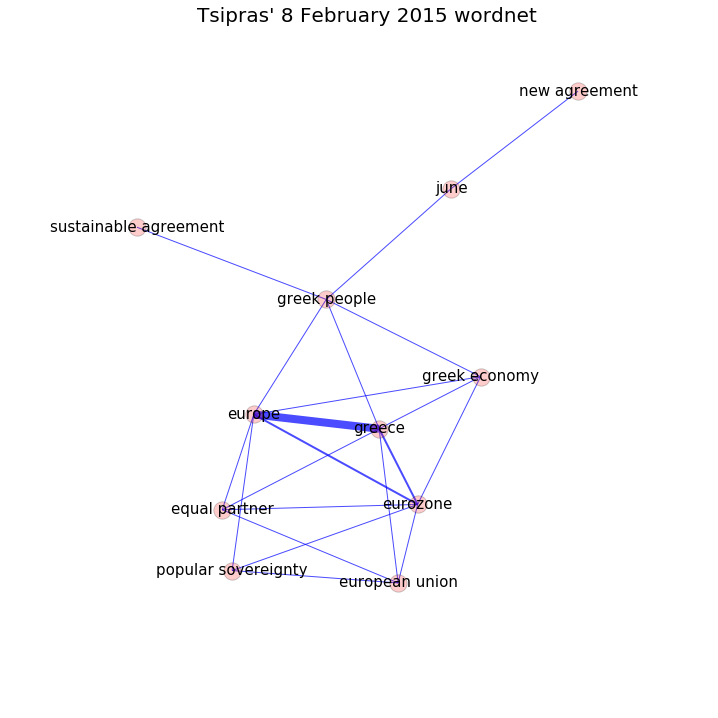

In [184]:
# Plotting the graph of common phrases in H Clinton's speech

from tools import draw_network
pos=nx.graphviz_layout(GHC)
# pos=nx.spring_layout(GHC)
sstt="%s wordnet" %title1
possit=draw_network(GHC,sstt,pos=pos,with_edgewidth=True,withLabels=True,labfs=15,valpha=0.2,ealpha=0.7,labelfont=15)

## Computing centralities of common phrases in the graph of Tsipras' 8 February 2015 speech

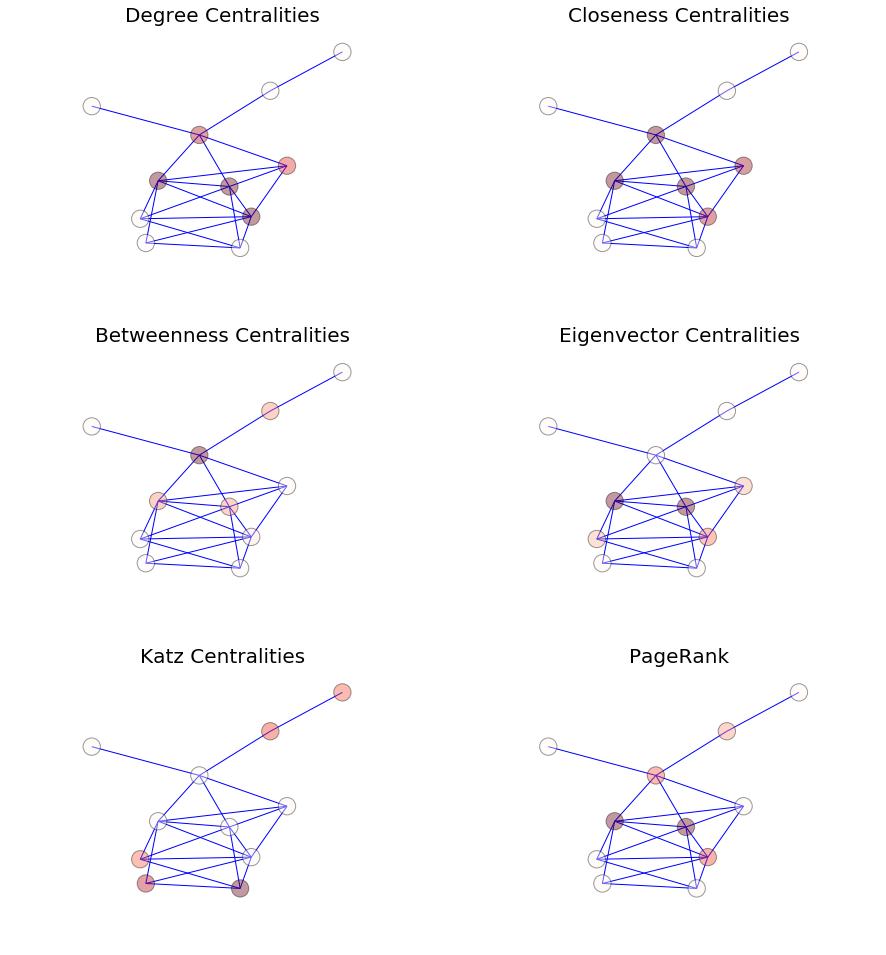

In [185]:
# Computing centralities of common phrases in the graph of H Clinton's speech

from tools import draw_centralities_subplots
centrali=draw_centralities_subplots(GHC,pos,withLabels=False,labfs=5,figsi=(15,22),ealpha=1,vals=True)

## The table of centralities of common phrases in the graph of Tsipras' 8 February 2015 speech

In [186]:
# The table of centralities of common phrases in the graph of H Clinton's speech

dfchc=pd.DataFrame()
dfchc.insert(0,'Common Nouns',centrali[centrali.keys()[0]].keys())
u=1
for i,k in centrali.items():
    dfchc.insert(u,i,k.values())
dfchc

,Common Nouns,degree_centrality,eigenvector_centrality,page_rank,betweenness_centrality,katz_centrality,closeness_centrality
0,europe,0.6,0.630272,0.192520,0.196296,-0.254455,0.666667
1,eurozone,0.6,0.311238,0.116832,0.050000,0.266557,0.555556
2,sustainable agreement,0.1,0.014798,0.031896,0.000000,0.156488,0.416667
3,greece,0.6,0.631148,0.042571,0.187037,-0.242829,0.666667
4,june,0.2,0.147191,0.068082,0.200000,0.338970,0.454545
5,popular sovereignty,0.3,0.172906,0.051729,0.005556,0.432556,0.476190
6,greek people,0.5,0.170437,0.107411,0.511111,0.102752,0.666667
7,new agreement,0.1,0.014949,0.192071,0.000000,0.300117,0.322581
8,greek economy,0.4,0.122634,0.067660,0.029630,0.016199,0.588235
9,equal partner,0.4,0.001503,0.063391,0.005556,0.284907,0.500000


## Detecting communities of common phrases in the graph of Tsipras' 8 February 2015 speech

Number of communities of Tsipras' 8 February 2015 wordnet = 3
Community partition of Tsipras' 8 February 2015 wordnet:
[[u'europe', u'greece'], [u'eurozone', u'popular sovereignty', u'equal partner', u'european union'], [u'sustainable agreement', u'new agreement', u'june', u'greek people', u'greek economy']]
Community modularity of Tsipras' 8 February 2015 wordnet = 0.2017


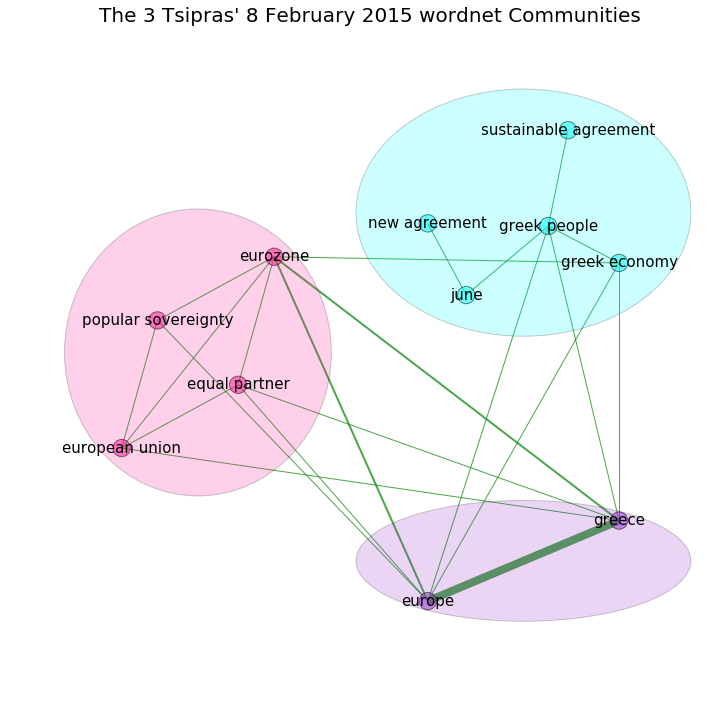

In [187]:
# Detecting communities of common phrases in the graph of H Clinton's speech

%autoreload 2
from tools import draw_comms, modul_arity, print_communities

part,nodper=print_communities(GHC,sstt)

d=0.8 
dd=0.8
c=1.2
cc=1.4
alpha=0.2
ealpha=.7
vcc={}
sstta="The %s %s Communities" %(max(part.values())+1,sstt)

draw_comms(GHC,GHC.nodes(),[],[],[] ,part,part,d,dd,c,cc,alpha,ealpha,nodper,sstta,titlefont=20,labelfont=15,valpha=0.5)

## Plotting the graph of common phrases in Tsipras' 11 July 2015 speech

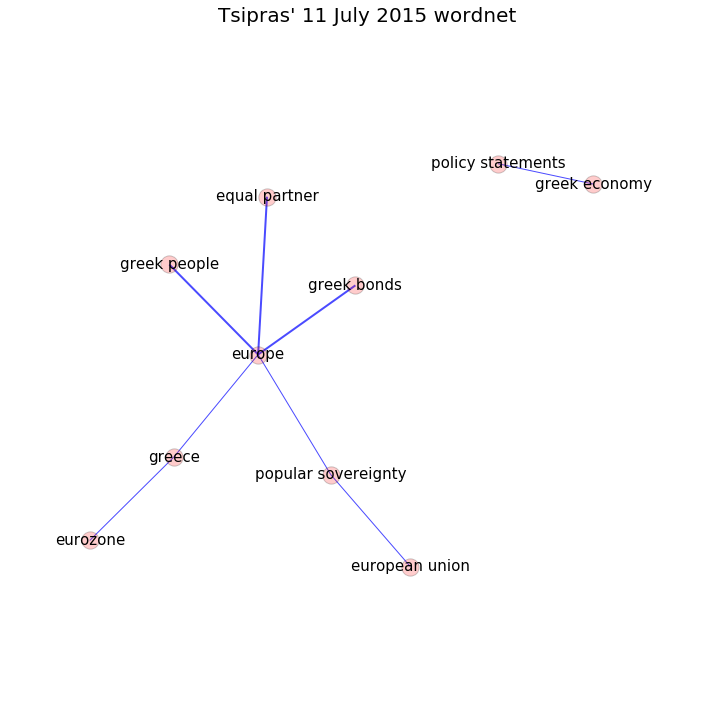

In [188]:
# Plotting the graph of common phrases in B Sanders' speech

pos=nx.graphviz_layout(GBS)
# pos=nx.spring_layout(GBS)
sstt="%s wordnet" %title2
posit=draw_network(GBS,sstt,pos=pos,with_edgewidth=True,withLabels=True,labfs=15,valpha=0.2,ealpha=0.7,labelfont=15)

## Computing centralities of common phrases in the graph of Tsipras' 11 July 2015 speech

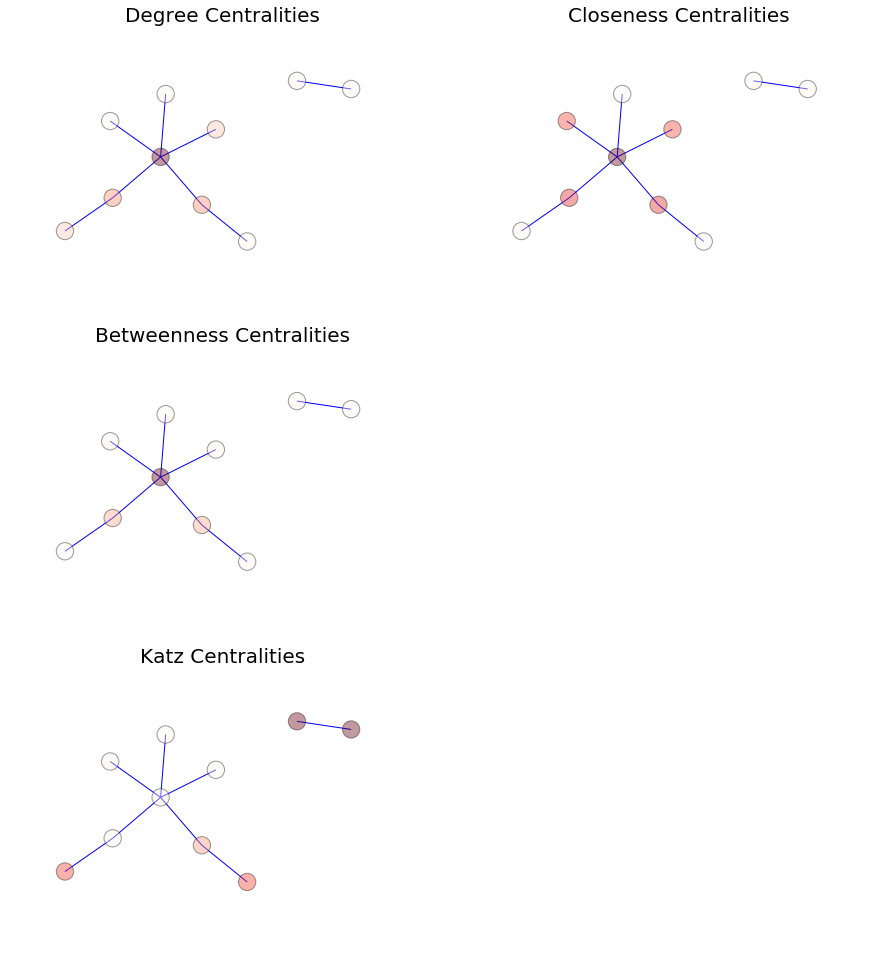

In [189]:
# Computing centralities of common phrases in the graph of B Sanders' speech

centrali=draw_centralities_subplots(GBS,pos,withLabels=False,labfs=5,figsi=(15,22),ealpha=1,vals=True)

## The table of centralities of common phrases in the graph of Tsipras' 11 July 2015 speech

In [190]:
# The table of centralities of common phrases in the graph of B Sanders' speech

dfcbs=pd.DataFrame()
dfcbs.insert(0,'Common Nouns',centrali[centrali.keys()[0]].keys())
u=1
for i,k in centrali.items():
#     print i,k
    try:
        dfcbs.insert(u,i,k.values())
    except:
        continue
dfcbs

,Common Nouns,degree_centrality,betweenness_centrality,katz_centrality,closeness_centrality
0,europe,0.555556,0.527778,-0.331388,0.604938
1,eurozone,0.111111,0.000000,0.308438,0.286550
2,greek bonds,0.111111,0.000000,-0.205903,0.362963
3,popular sovereignty,0.222222,0.166667,0.183133,0.418803
4,greek people,0.111111,0.000000,-0.205903,0.362963
5,policy statements,0.111111,0.000000,0.502817,0.111111
6,greece,0.222222,0.166667,0.183133,0.418803
7,greek economy,0.111111,0.000000,0.502817,0.111111
8,equal partner,0.111111,0.000000,-0.205903,0.362963
9,european union,0.111111,0.000000,0.308438,0.286550


## Detecting communities of common phrases in the graph of Tsipras' 11 July speech

Number of communities of Tsipras' 11 July 2015 wordnet = 4
Community partition of Tsipras' 11 July 2015 wordnet:
[[u'europe', u'greek bonds', u'greek people', u'equal partner'], [u'eurozone', u'greece'], [u'popular sovereignty', u'european union'], [u'policy statements', u'greek economy']]
Community modularity of Tsipras' 11 July 2015 wordnet = 0.3678


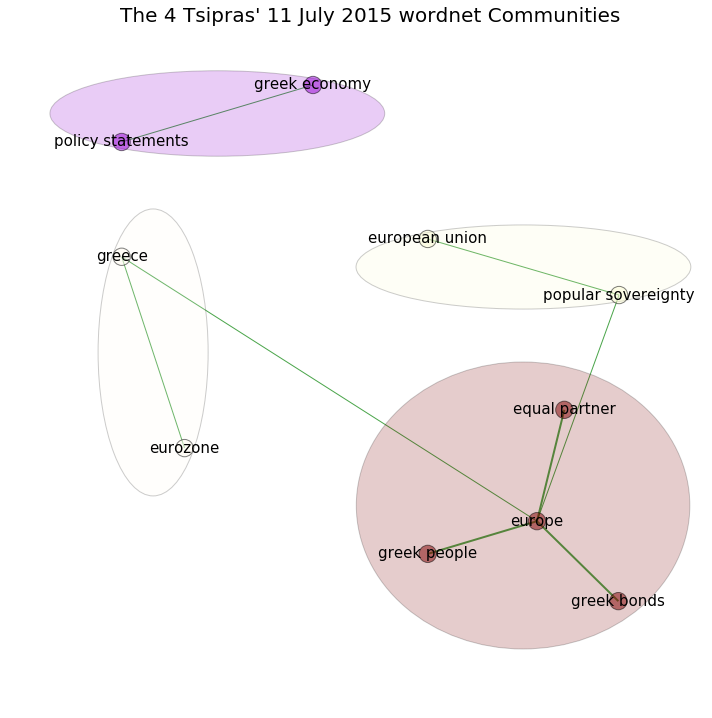

In [191]:
# Detecting communities of common phrases in the graph of B Sanders' speech

%autoreload 2
part,nodper=print_communities(GBS,sstt)

d=0.8 
dd=0.8
c=1.2
cc=1.4
alpha=0.2
ealpha=.7
vcc={}
sstta="The %s %s Communities" %(max(part.values())+1,sstt)

draw_comms(GBS,GBS.nodes(),[],[],[] ,part,part,d,dd,c,cc,alpha,ealpha,nodper,sstta,titlefont=20,labelfont=15,valpha=0.5)

## Plotting the Tsipras' 8 February vs. 11 July 2015 wordnet 

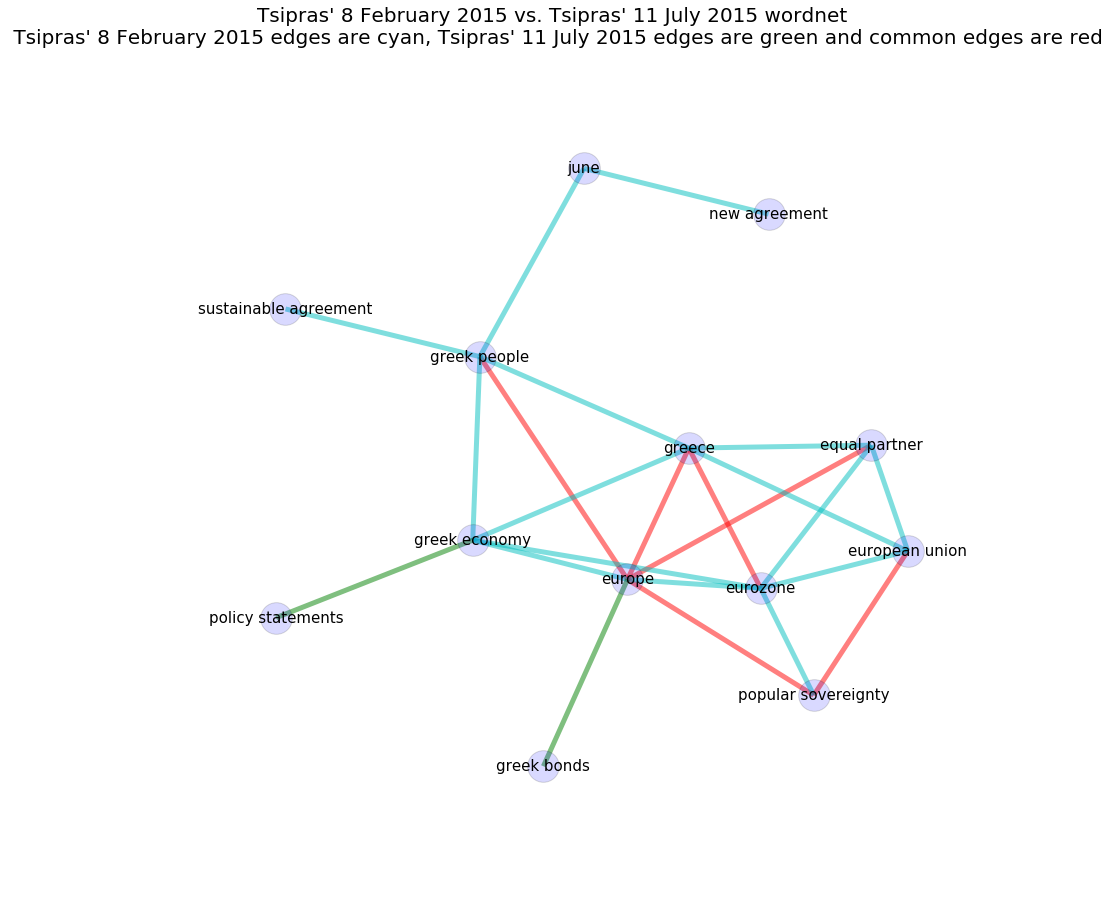

In [192]:
# Plotting the Hilary Clinton vs. Bernie Sanders wordnet

G = nx.Graph()
G.add_edges_from(GHC.edges())
G.add_edges_from(GBS.edges())
# pos=nx.graphviz_layout(G)
pos=nx.spring_layout(G)
sstt="%s vs. %s wordnet \n %s edges are cyan, %s edges are green and common edges are red" %(title1,title2,title1,title2)
plt.figure(figsize=(15,15))
common_edges=set(GHC.edges()).intersection(set(GBS.edges()))
HCandBSedges = list(common_edges)
Cedges=set(GHC.edges()).difference(set(GBS.edges()))
HCedges = list(Cedges)
Sedges=set(GBS.edges()).difference(set(GHC.edges()))
BSedges = list(Sedges)
nx.draw_networkx_nodes(G,pos,withLabels=True,node_color='b',node_size=1000,alpha=0.15)
nx.draw_networkx_edges(G,pos,edgelist=HCandBSedges,width=5,alpha=0.5,edge_color='r')
nx.draw_networkx_edges(G,pos,edgelist=HCedges,width=5,alpha=0.5,edge_color='c')
nx.draw_networkx_edges(G,pos,edgelist=BSedges,width=5,alpha=0.5,edge_color='g')
nx.draw_networkx_labels(G,pos=pos,font_size=15)
plt.title(sstt,fontsize=20)
kk=plt.axis('off')